# Workshop 5. Cross Entropy Method

**[CE716: Reinforcement Learning](https://deeprlcourse.github.io/)**

__Course Instructor__: Dr. Mohammad Hossein Rohban

__Notebook Author__: Ramtin Moslemi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Workshop-5-Material/blob/main/CEM.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Workshop-5-Material/main/CEM.ipynb)

---
## Notebook Objectives

Welcome to this workshop on **Reinforcement Learning (RL)**!

In this notebook, we implement the **Cross Entropy Method (CEM)**, which is a Stochastic Optimization method, on the [Mountain Car Continuous](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) environment.
CEM iteratively suggests a small number of neighboring policies, and uses a small percentage of the best performing policies to calculate a new estimate.

This notebook is heavily inspired by Chanseok Kang's [notebook on Cross Entropy Methods](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/11/CEM-MountainCar.html).

In [1]:
# @title Imports

import gymnasium as gym
import math
import numpy as np
from collections import deque
from tqdm.notebook import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import base64, io

# For visualization
import logging
from IPython.display import HTML
import matplotlib
from matplotlib import pyplot as plt
import imageio
import glob

In [2]:
# @title Device setup

# You're probably better off using cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# @title Helper functions

logging.getLogger().setLevel(logging.ERROR)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return HTML(tag)


def create_policy_eval_video(env, agent, filename, format='mp4', max_steps=1000, num_episodes=1):
    filename = filename + ".mp4"
    fps = env.metadata['render_fps']
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            counter = 0
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                action = agent.act(state)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                counter += 1
                if terminated or truncated or counter > max_steps:
                    break
    return embed_mp4(filename)


def plot_rewards(scores):
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

# Instantiate the Environment

MountainCar environment has two types: Discrete and Continuous. In this notebook, we used Continuous version of MountainCar. That is, we can move the car to the left (or right) precisely.

In [4]:
env = gym.make('MountainCarContinuous-v0')

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
  - low: [-1.]
  - high: [1.]


# Agent

This Agent class implements a simple neural network for reinforcement learning.
It consists of a two-layer fully connected network and can evaluate different sets of weights in an environment.
The agent selects actions based on the learned policy and can be evaluated by running episodes using the provided weights.

In [5]:
class Agent(nn.Module):
    """
    A simple neural network agent for reinforcement learning. The agent consists of a two-layer fully connected network
    and can evaluate different sets of weights. It interacts with a given environment by selecting actions based on
    learned policies.
    """

    def __init__(self, env: gym.Env, h_size: int = 16) -> None:
        """Initializes the agent with a given environment and network structure."""
        super().__init__()
        self.env = env
        self.s_size: int = env.observation_space.shape[0]  # State dimension
        self.h_size: int = h_size  # Hidden layer size
        self.a_size: int = env.action_space.shape[0]  # Action dimension

        # Define a two-layer fully connected network
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)

    def set_weights(self, weights: np.ndarray) -> None:
        """Sets the network weights from a given flattened array."""
        fc1_end = (self.s_size * self.h_size) + self.h_size

        fc1_W = torch.from_numpy(weights[: self.s_size * self.h_size].reshape(self.s_size, self.h_size))
        fc1_b = torch.from_numpy(weights[self.s_size * self.h_size : fc1_end])

        fc2_W = torch.from_numpy(weights[fc1_end : fc1_end + (self.h_size * self.a_size)].reshape(self.h_size, self.a_size))
        fc2_b = torch.from_numpy(weights[fc1_end + (self.h_size * self.a_size) :])

        # Assign new weights to network layers
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

    def get_weights_dim(self) -> int:
        """Returns the total number of parameters in the network."""
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the network."""
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data

    def act(self, state: np.ndarray) -> torch.Tensor:
        """Selects an action given a state."""
        state_tensor = torch.from_numpy(state).float().to(device)
        with torch.no_grad():
            action = self.forward(state_tensor)
        return action

    def evaluate(self, weights: np.ndarray, gamma: float = 1.0, max_t: int = 5000) -> float:
        """Evaluates the agent's performance by running an episode with a given set of weights."""
        self.set_weights(weights)
        episode_return = 0.0
        state, _ = self.env.reset()

        for t in range(max_t):
            state_tensor = torch.from_numpy(state).float().to(device)
            action = self.forward(state_tensor)
            state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
            episode_return += reward * (gamma ** t)
            if terminated or truncated:
                break

        return episode_return


# Cross Entropy Method

The cem function implements the Cross-Entropy Method (CEM) to optimize an agent's policy in a reinforcement learning setting.
It iteratively samples a population of candidate weight vectors by adding Gaussian noise to the current best weights and evaluates their performance in the environment.
The top-performing candidates (elite set) are selected, and their average is used to update the best weights.
This process continues for a specified number of iterations or until the agent achieves an average score above 90 over the last 100 episodes.
The function also saves the agent's model after each iteration and provides progress updates.

In [6]:
def cem(agent, n_iterations: int = 300, max_t: int = 1000, gamma: float = 1.0,
        pop_size: int = 100, elite_frac: float = 0.2, sigma: float = 0.5):
    """
    PyTorch implementation of the cross-entropy method (CEM) for optimizing agent policies.

    Parameters:
    - agent: The agent instance to be optimized.
    - n_iterations: Number of training iterations.
    - max_t: Maximum number of timesteps per episode.
    - gamma: Discount factor for rewards.
    - pop_size: Population size at each iteration.
    - elite_frac: Fraction of top-performing candidates used to update weights.
    - sigma: Standard deviation of additive noise.

    Returns:
    - scores: A list of cumulative rewards obtained over iterations.
    """
    n_elite = int(pop_size * elite_frac)
    scores_deque = deque(maxlen=100)
    scores = []

    # Initialize weights with random noise
    best_weight = sigma * np.random.randn(agent.get_weights_dim())

    for i_iteration in (pbar := trange(1, n_iterations + 1)):
        # Generate candidate weights with Gaussian noise
        weights_pop = [best_weight + sigma * np.random.randn(agent.get_weights_dim()) for _ in range(pop_size)]

        # Evaluate all candidates
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        # Select elite candidates
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]

        # Update best weights
        best_weight = np.mean(elite_weights, axis=0)

        # Evaluate updated weights
        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)

        pbar.set_description(f'Average Score = {np.mean(scores_deque):.2f}')

        # Check if environment is solved
        if np.mean(scores_deque) >= 90.0:
            print(f'\nEnvironment solved in {i_iteration - 100} iterations!\tAverage Score: {np.mean(scores_deque):.2f}\n')
            break

    # Save model checkpoint
    torch.save(agent.state_dict(), 'checkpoint.pth')

    # Plot results
    plot_rewards(scores)

    return scores


# Results

  0%|          | 0/300 [00:00<?, ?it/s]


Environment solved in 93 iterations!	Average Score: 90.08



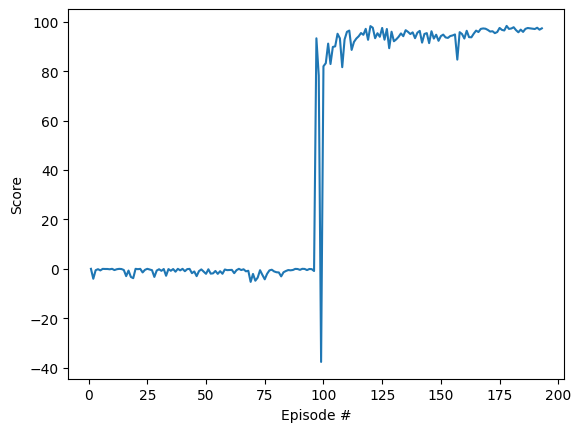

In [7]:
torch.manual_seed(2025)

agent = Agent(env).to(device)
scores = cem(agent)

In [8]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
create_policy_eval_video(env, agent, 'cem')

# Vectorized Version

One of the major advantages of the **CEM** is that it is **Parallelizable**!

In this section we explore how **Vectorized** environments allow us to take advantage of this fact.

## Vectorized Agent

To utilize the benefits of vectorization, we must implement our agent once more to support batch evaluations on vectorized environments.

In [9]:
class VectorizedAgent:
    """
    Handles batched weight evaluations using parallel environments and GPU acceleration.
    """
    def __init__(self, env_maker, pop_size: int = 100, h_size: int = 16):
        self.pop_size = pop_size
        self.vec_env = gym.vector.SyncVectorEnv([env_maker for _ in range(pop_size)])
        self.s_size = self.vec_env.single_observation_space.shape[0]
        self.h_size = h_size
        self.a_size = self.vec_env.single_action_space.shape[0]

        # Pre-calculate weight slicing indices
        self.fc1_end = self.s_size * self.h_size
        self.fc1_b_end = self.fc1_end + self.h_size
        self.fc2_end = self.fc1_b_end + self.h_size * self.a_size
        self.total_params = self.fc2_end + self.a_size

    def batched_forward(self, states: np.ndarray, weights_batch: np.ndarray) -> np.ndarray:
        # Convert to tensors and move to GPU
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=device)
        weights_tensor = torch.as_tensor(weights_batch, dtype=torch.float32, device=device)

        # Split weights into layer components
        fc1_W = weights_tensor[:, :self.fc1_end].view(-1, self.s_size, self.h_size)
        fc1_b = weights_tensor[:, self.fc1_end:self.fc1_b_end].view(-1, self.h_size)
        fc2_W = weights_tensor[:, self.fc1_b_end:self.fc2_end].view(-1, self.h_size, self.a_size)
        fc2_b = weights_tensor[:, self.fc2_end:].view(-1, self.a_size)

        # Batched forward pass
        x = torch.einsum('bs,bsh->bh', states_tensor, fc1_W) + fc1_b
        x = F.relu(x)
        x = torch.einsum('bh,bha->ba', x, fc2_W) + fc2_b
        return torch.tanh(x).cpu().numpy()

    def evaluate_batch(self, weights_batch: np.ndarray, gamma: float = 1.0, max_t: int = 1000) -> np.ndarray:
        states, _ = self.vec_env.reset()
        episode_returns = np.zeros(self.pop_size)
        discount = 1.0

        for _ in range(max_t):
            actions = self.batched_forward(states, weights_batch)
            next_states, rewards, _, _, _ = self.vec_env.step(actions)
            episode_returns += rewards * discount
            discount *= gamma
            states = next_states

        return episode_returns

    def save_weights(self, filepath: str, weights: np.ndarray):
        """
        Save the agent's weights to a file.
        """
        torch.save(torch.from_numpy(weights), filepath)

    def load_weights(self, filepath: str) -> np.ndarray:
        """
        Load the agent's weights from a file.
        """
        return torch.load(filepath).numpy()

## Parallel CEM

Now we can modify the `cem` method as well to support the vectorized agents.

In [10]:
# Create the environment maker function
def make_env():
    return gym.make("MountainCarContinuous-v0")


def cem(env_maker = make_env, n_iterations: int = 300, pop_size: int = 100,
        elite_frac: float = 0.2, sigma: float = 0.5, h_size: int = 16):
    agent = VectorizedAgent(env_maker, pop_size, h_size)
    n_elite = int(pop_size * elite_frac)
    best_weight = sigma * np.random.randn(agent.total_params)
    scores_deque = deque(maxlen=100)
    scores = []

    for _ in (pbar := trange(n_iterations)):
        # Generate population (batched on CPU)
        weights_batch = best_weight + sigma * np.random.randn(pop_size, agent.total_params)

        # Evaluate entire population in parallel
        rewards = agent.evaluate_batch(weights_batch)

        # Elite selection (GPU not needed here)
        elite_idx = np.argsort(rewards)[-n_elite:]
        elite_weights = weights_batch[elite_idx]
        best_weight = elite_weights.mean(axis=0)

        # Track performance
        scores.append(rewards.mean())
        scores_deque.append(rewards.mean())
        pbar.set_description(f'Average Reward = {scores[-1]:.2f} ')

    # Save model checkpoint
    agent.save_weights("best_weights.pth", best_weight)

    # Plot results
    plot_rewards(scores)

    return scores

## Speed Up Results

As you can see our new iterations take less time even with larger networks and population sizes!
Keep in mind the average reward reported here refers to the average reward of the entire population!

  0%|          | 0/300 [00:00<?, ?it/s]

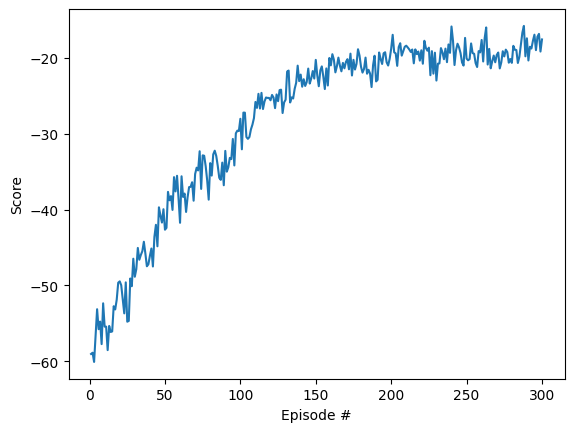

In [11]:
# Run CEM on MountainCarContinuous-v0
scores = cem(n_iterations=300,  # Number of training iterations
             pop_size=300,      # Population size
             elite_frac=0.2,    # Fraction of elite candidates
             sigma=0.5,         # Noise scale
             h_size=32          # Hidden layer size
             )